In [1]:
import os
# os.environ['MUSDB_PATH'] = '/root/MUSDB18/MUSDB18-7' # <- change to local dataset path

import sys
sys.path.append(os.path.abspath('../'))

In [2]:
import musdb

mus_train = musdb.DB(subsets="train", split='train')
mus_valid = musdb.DB(subsets="train", split='valid')

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from torchmetrics.functional import signal_distortion_ratio
from torchinfo import summary
import musdb, museval
import torch
import transforms
import utils
from mmdensenet import MMDenseNet
from datasets import STFTDataset, SamplingTrackDataset, FullTrackDataset
from tqdm.notebook import tqdm

torch.cuda.device_count()

1

In [4]:
seed = 42

torch.manual_seed(seed)
rng = np.random.default_rng(seed)

train_size, valid_size = 86, 14
sample_length_seconds = 5
sample_length_seconds_valid = 15
batch_size = 8
valid_batch_size = 8

training_data = SamplingTrackDataset(mus_train.tracks[:train_size], seconds=sample_length_seconds, target='vocals', rng=rng)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

valid_data = FullTrackDataset(mus_valid.tracks[:valid_size], seconds=sample_length_seconds_valid, target='vocals')
valid_loader = DataLoader(valid_data, batch_size=valid_batch_size)

In [5]:
in_channels, num_features = 2, 32

# growth_rate = [12,12,12,12,12,12,12]
growth_rate = [10,10,10,10,10,10,10]
kernel_size = 3

dilated = [True] * len(growth_rate)
norm = [True] * len(growth_rate)
nonlinear = [True] * len(growth_rate)
# depth = [4,4,4,4,4,4,4]
depth = [3,3,3,3,3,3,3]

growth_rate_final=4
kernel_size_final=3
depth_final=2
dilated_final=True
norm_final=True
nonlinear_final=True

model = MMDenseNet(in_channels, num_features, growth_rate, kernel_size, dilated=dilated, norm=norm, nonlinear=nonlinear, depth=depth,
    growth_rate_final=growth_rate_final, kernel_size_final=kernel_size_final, depth_final=depth_final,
    dilated_final=dilated_final, norm_final=norm_final, nonlinear_final=nonlinear_final)
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

summary(model)


Layer (type:depth-idx)                                            Param #
MMDenseNet                                                        --
├─BandSplit: 1-1                                                  --
├─ModuleDict: 1-2                                                 --
│    └─MDenseNetBackbone: 2-1                                     --
│    │    └─Conv2d: 3-1                                           608
│    │    └─Encoder: 3-2                                          22,544
│    │    └─DenseBlock: 3-3                                       5,520
│    │    └─Decoder: 3-4                                          26,010
│    └─MDenseNetBackbone: 2-2                                     --
│    │    └─Conv2d: 3-5                                           608
│    │    └─Encoder: 3-6                                          22,544
│    │    └─DenseBlock: 3-7                                       5,520
│    │    └─Decoder: 3-8                                          26,010
│    

In [6]:
epochs = 150
train_losses, valid_losses = [], []

for epoch in tqdm(range(epochs)):

    model.train()
    train_loss = []
    for i, (mixture, target) in enumerate(train_loader):

        optimizer.zero_grad()
        # magnitude, phase = torch.abs(mixture), torch.angle(mixture)
        # outputs = model(magnitude) * torch.exp(1j * phase)
        outputs = model(torch.abs(mixture))

        loss = loss_fn(outputs, torch.abs(target))
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
    
    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)

    if epoch == 0 or (epoch + 1) % 10 == 0:
        model.eval()
        valid_loss = []
        with torch.no_grad():
            for i, (mixture, target) in enumerate(valid_loader):

                outputs = model(torch.abs(mixture))

                loss = loss_fn(outputs, torch.abs(target))
                valid_loss.append(loss.item())

        valid_loss = np.mean(valid_loss)
        valid_losses.append(valid_loss)
    
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f'epoch {epoch}: train loss {train_loss:3f} valid loss {valid_loss:3f}')
    else:
        print(f'epoch {epoch}: train loss {train_loss:3f}')

    if (epoch + 1) % 20 == 0:
        model_path = os.path.join('../../models/mmdensenet', f'trained_model_epoch_{epoch+1}.pt')
        torch.save(model.state_dict(), model_path)

    del outputs, loss

  0%|          | 0/150 [00:00<?, ?it/s]

epoch 0: train loss 4.952699 valid loss 4.547267
epoch 1: train loss 3.663147
epoch 2: train loss 3.258722
epoch 3: train loss 2.787051
epoch 4: train loss 2.864985
epoch 5: train loss 2.778631
epoch 6: train loss 2.916975
epoch 7: train loss 2.464793
epoch 8: train loss 2.060636
epoch 9: train loss 2.380677 valid loss 1.815707
epoch 10: train loss 2.174084
epoch 11: train loss 2.371435
epoch 12: train loss 2.286122
epoch 13: train loss 2.014711
epoch 14: train loss 1.799442
epoch 15: train loss 1.801791
epoch 16: train loss 1.596562
epoch 17: train loss 2.077270
epoch 18: train loss 1.861107
epoch 19: train loss 2.022038 valid loss 1.863854
epoch 20: train loss 1.996609
epoch 21: train loss 1.667262
epoch 22: train loss 2.000915
epoch 23: train loss 1.826760
epoch 24: train loss 1.993319
epoch 25: train loss 1.665585
epoch 26: train loss 1.530066
epoch 27: train loss 1.437277
epoch 28: train loss 1.422860
epoch 29: train loss 1.956025 valid loss 1.661258
epoch 30: train loss 1.750272


In [7]:
model_path = os.path.join('../../models/mmdensenet', f'trained_model_epoch_{epochs}.pt')
torch.save(model.cpu().state_dict(), model_path)
torch.save(model.get_config(), os.path.join('../../models/mmdensenet', f'model_config.pt'))
print(f'Done, model saved at {model_path}')

Done, model saved at ../../models/mmdensenet/trained_model_epoch_150.pt


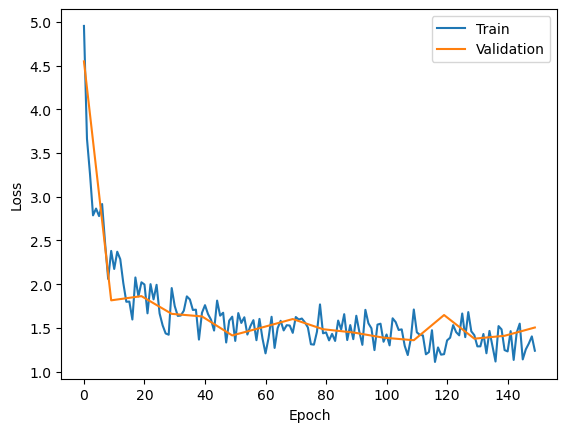

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot([0,9,19,29,39,49,59,69,79,89,99,109,119,129,139,149], valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [5]:
model = MMDenseNet.build_model('../../models/mmdensenet/model_config.pt')
model.load_state_dict(torch.load('../../models/mmdensenet/trained_model_epoch_150.pt'))

<All keys matched successfully>

In [6]:
import scipy.io.wavfile

model.cuda()
model.eval()
sdrs = []
preds, targets = [], []
with torch.no_grad():
    for i, track in tqdm(enumerate(mus_valid.tracks)):
        print(i, track)
        mixture_track, target_track, pred_track = [], [], []
        for (mixture_audio, target_audio) in utils.slice_musdb_track_iterator(track, 60., sample_targets='vocals'):
            mixture = transforms.stft(torch.tensor(mixture_audio[None], dtype=torch.float))
            output = model(torch.abs(mixture)) * torch.exp(1j * torch.angle(mixture))
            pred_audio = transforms.istft(output, device='cpu')[0]
            pred_track.append(pred_audio)
            mixture_track.append(torch.tensor(mixture_audio[:,:pred_audio.size(-1)], device='cpu'))
            target_track.append(torch.tensor(target_audio[:,:pred_audio.size(-1)], device='cpu'))

        mixture_track = torch.cat(mixture_track, dim=1).numpy().T
        target_track = torch.cat(target_track, dim=1).numpy().T
        pred_track = torch.cat(pred_track, dim=1).numpy().T

        sdr, _, _, _ = museval.metrics.bss_eval_sources([target_track], [pred_track], compute_permutation=False)
        print(sdr[0][0])
        sdrs.append(sdr)

print(np.mean(sdrs))

0it [00:00, ?it/s]

0 ANiMAL - Rockshow
2.641290475083546
1 Actions - One Minute Smile
2.9426740630512582
2 Alexander Ross - Goodbye Bolero
5.634995304055157
3 Clara Berry And Wooldog - Waltz For My Victims
3.4326357256995275
4 Fergessen - Nos Palpitants
10.052529142106088
5 James May - On The Line
7.692067335558537
6 Johnny Lokke - Promises & Lies
6.612074592844621
7 Leaf - Summerghost
4.23879242082261
8 Meaxic - Take A Step
4.139675447997511
9 Patrick Talbot - A Reason To Leave
7.603413408799355
10 Skelpolu - Human Mistakes
1.235989631255899
11 Traffic Experiment - Sirens
-0.055249779994320874
12 Triviul - Angelsaint
5.258396823391793
13 Young Griffo - Pennies
5.652547433782766
4.791559430318167


In [7]:
print("validation results")
print("mean:", np.mean(sdrs))
print("median:", np.median(sdrs))
print("std:", np.std(sdrs))

validation results
mean: 4.791559430318167
median: 4.748594622107202
std: 2.6149981666651545


In [8]:
mus_test = musdb.DB(subsets="test")

model.cuda()
model.eval()
sdrs = []
preds, targets = [], []
with torch.no_grad():
    for i in tqdm(range(len(mus_test.tracks))):
        track = mus_test.tracks[i]
        print(i, track)
        mixture_track, target_track, pred_track = [], [], []
        for (mixture_audio, target_audio) in utils.slice_musdb_track_iterator(track, 60., sample_targets='vocals'):
            mixture = transforms.stft(torch.tensor(mixture_audio[None], dtype=torch.float))
            output = model(torch.abs(mixture)) * torch.exp(1j * torch.angle(mixture))
            pred_audio = transforms.istft(output, device='cpu')[0]
            pred_track.append(pred_audio)
            mixture_track.append(torch.tensor(mixture_audio[:,:pred_audio.size(-1)], device='cpu'))
            target_track.append(torch.tensor(target_audio[:,:pred_audio.size(-1)], device='cpu'))

        mixture_track = torch.cat(mixture_track, dim=1).numpy().T
        target_track = torch.cat(target_track, dim=1).numpy().T
        pred_track = torch.cat(pred_track, dim=1).numpy().T

        sdr, _, _, _ = museval.metrics.bss_eval_sources([target_track], [pred_track], compute_permutation=False)
        print(sdr[0][0])
        sdrs.append(sdr[0][0])

sdr = np.mean(sdrs)
print('final sdr', sdr)

  0%|          | 0/50 [00:00<?, ?it/s]

0 AM Contra - Heart Peripheral
5.9343247756170285
1 Al James - Schoolboy Facination
3.585716372595609
2 Angels In Amplifiers - I'm Alright
5.802745947317101
3 Arise - Run Run Run
3.596823589882434
4 BKS - Bulldozer
2.4030183574736306
5 BKS - Too Much
7.2099806825396655
6 Ben Carrigan - We'll Talk About It All Tonight
1.729487199154522
7 Bobby Nobody - Stitch Up
4.3372499406222955
8 Buitraker - Revo X
0.1091239635858964
9 Carlos Gonzalez - A Place For Us
3.526174862664684
10 Cristina Vane - So Easy
5.6894920043460235
11 Detsky Sad - Walkie Talkie
2.0847919196408586
12 Enda Reilly - Cur An Long Ag Seol
6.981622697347035
13 Forkupines - Semantics
1.9955284036954668
14 Georgia Wonder - Siren
1.2830351537172366
15 Girls Under Glass - We Feel Alright
3.0075699442322943
16 Hollow Ground - Ill Fate
2.507682785883821
17 James Elder & Mark M Thompson - The English Actor
5.318457315599609
18 Juliet's Rescue - Heartbeats
4.953915924678537
19 Little Chicago's Finest - My Own
4.70613895329538
20 Lou

In [9]:
print("test results")
print("mean:", np.mean(sdrs))
print("median:", np.median(sdrs))
print("std:", np.std(sdrs))

test results
mean: 3.6754498563973628
median: 4.460720054387498
std: 4.424827905048307
